In [0]:
import numpy as np 
import torch
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.optim as optim 
from torchvision import transforms
from tqdm import *
import matplotlib.pyplot as plt
import pickle 
import random 

In [0]:
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = LeNet().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model.eval()

CUDA Available:  False


LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
SoftmaxWithXent = nn.CrossEntropyLoss()

In [0]:
noises = [] 
y_preds = []
y_preds_adversarial = [] 
totalMisclassifications = 0
xs_clean = [] 
y_trues_clean = []

In [0]:
for x, y_true in test_loader:
    # Wrap x as a variable 
    x = Variable(torch.FloatTensor(x), requires_grad=True)
    y_true = Variable(torch.LongTensor(np.array([y_true])), requires_grad=False)

    # Classification before Adv 
    y_pred =  np.argmax(model(x).data.numpy())
    
    # Generate Adversarial Image 

    # Forward pass
    outputs = model(x)
    loss = SoftmaxWithXent(outputs, y_true)
    loss.backward() # obtain gradients on x

     # Add perturbation
    epsilon = 0.5
    x_grad   = torch.sign(x.grad.data)
    x_adversarial = torch.clamp(x.data + epsilon * x_grad, 0, 1) 

    # Classification after optimization  
    y_pred_adversarial = np.argmax(model(Variable(x_adversarial)).data.numpy())
    # print "Before: {} | after: {}".format(y_pred, y_pred_adversarial)
    
    # print "Y_TRUE: {} | Y_PRED: {}".format(_y_true, y_pred)
    if y_true.data.numpy() != y_pred:
        totalMisclassifications += 1
    else:
        y_preds.append(y_pred)
        y_preds_adversarial.append(y_pred_adversarial)
        noises.append( (x_adversarial - x.data).numpy() ) 
        xs_clean.append(x.data.numpy())
        y_trues_clean.append(y_true.data.numpy())


In [33]:
print ("Total totalMisclassifications : ", totalMisclassifications)

Total totalMisclassifications :  190


In [0]:
with open("bulk_mnist_fgsd.pkl","wb") as f: 
    adv_data_dict = {
            "xs" : xs_clean, 
            "y_trues" : y_trues_clean,
            "y_preds" : y_preds,
            "noises" : noises,
            "y_preds_adversarial" : y_preds_adversarial
            }    
    pickle.dump(adv_data_dict, f)

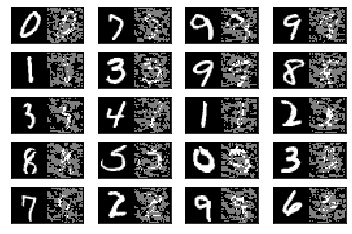

Adv examples: max, min:  1.0 0.0
Noise: Mean, Max, Min: 
0.17571296 0.5 -0.5


In [35]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import sys, os 

f = open("bulk_mnist_fgsd.pkl", "rb")
adv_data_dict = pickle.load(f) 

xs = adv_data_dict["xs"]
y_trues = adv_data_dict["y_trues"]
y_preds = adv_data_dict["y_preds"]
noises  = adv_data_dict["noises"]
y_preds_adversarial = adv_data_dict["y_preds_adversarial"]  


# import ipdb; ipdb.set_trace()
# visualize N random images 
idxs = np.random.choice(range(50), size=(20,), replace=False)
for matidx, idx in enumerate(idxs):
    orig_im = xs[idx].reshape(28,28)
    adv_im  = orig_im + noises[idx].reshape(28,28)
    disp_im = np.concatenate((orig_im, adv_im), axis=1)
    plt.subplot(5,4,matidx+1)
    plt.imshow(disp_im, "gray")
    plt.xticks([])
    plt.yticks([])
plt.show()
    
# Noise statistics 
# import ipdb; ipdb.set_trace()
noises, xs, y_trues, y_preds = np.array(noises), np.array(xs), np.array(y_trues), np.array(y_preds)
noises = noises.squeeze(axis=1)
xs = xs.squeeze(axis=1)
adv_exs = xs + noises  
print ("Adv examples: max, min: ", adv_exs.max(), adv_exs.min())
print ("Noise: Mean, Max, Min: ")
print (np.mean(noises), np.max(noises), np.min(noises))

In [42]:
for i in range(20):
  print("real: " + str(y_trues[i][0]) + " || " + "predicted: " + str(y_preds[i]) + " || adversial: " + str(y_preds_adversarial[i]))

real: 6 || predicted: 6 || adversial: 8
real: 1 || predicted: 1 || adversial: 8
real: 9 || predicted: 9 || adversial: 2
real: 2 || predicted: 2 || adversial: 8
real: 2 || predicted: 2 || adversial: 8
real: 1 || predicted: 1 || adversial: 8
real: 9 || predicted: 9 || adversial: 8
real: 2 || predicted: 2 || adversial: 8
real: 9 || predicted: 9 || adversial: 8
real: 9 || predicted: 9 || adversial: 8
real: 0 || predicted: 0 || adversial: 2
real: 6 || predicted: 6 || adversial: 2
real: 0 || predicted: 0 || adversial: 8
real: 1 || predicted: 1 || adversial: 5
real: 9 || predicted: 9 || adversial: 8
real: 1 || predicted: 1 || adversial: 8
real: 1 || predicted: 1 || adversial: 8
real: 7 || predicted: 7 || adversial: 8
real: 1 || predicted: 1 || adversial: 8
real: 0 || predicted: 0 || adversial: 2
